# Sample-Reference distance vs. sample-sample distnace

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

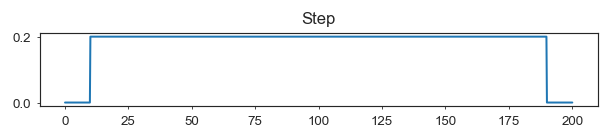

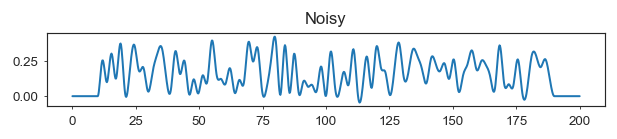

In [6]:
from neuroprobnum.utils import stim_utils
t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        t0=t0, tmax=tmax, t_eval_adaptive=math_utils.t_arange(t0, tmax, 5),
        return_vars=['events', 'ys'],
        model=neuron, y0=neuron.compute_yinf(-65), thresh=0.0,
        n_samples=100, n_parallel=20,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data'
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

Not acc sols file found!
Not acc sols file found!


## Data

In [8]:
# pert_method, adaptive, methods, step_params
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.5, 0.25, 0.1, 0.025, 0.01, 0.005]),
    ('abdulle_ln', 0, ['EEMP'], [0.5, 0.25, 0.1, 0.025, 0.01]),
    ('abdulle_ln', 0, ['FE'], [0.05, 0.025, 0.01, 0.005]),
    ('conrad', 1, ['RKBS'], [1e-2, 1e-4, 1e-6]),
]

In [9]:
for stim, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------')
    
    for pert_method, adaptive, methods, step_params in solver_params:
        for step_param, method in itproduct(step_params, methods):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, overwrite=False, allowgenerror=False,
            )

----------------------------------------------------------
IStimStep(0.2,t=[10,190]) : stim_Step_tmax_200
----------------------------------------------------------
                                 EE_f(0.5)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 0 acc_ts. Create reference solution!
2 times the following warning: inefficient
                                EE_f(0.25)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 1 acc_ts. Create reference solution!
2 times the following warning: inefficient
                                 EE_f(0.1)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 2 acc_ts. Create reference solution!
2 times the following warning: inefficient
                               EE_f(0.025)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 3 acc_ts. Create reference solution!
                          

# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, allowgenerror=True)   
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    df = df.append(stim_df, ignore_index=True)

In [11]:
df.head()

,MAE_DR,MAE_SM,MAE_SR,acc_events,acc_ts,acc_vs,adaptive,det_events,det_nODEcalls,det_run_time,...,pert_method,pert_param,run_times,step_param,t0,tmax,ts,vs,stimfun,stim
0,22.167441,"[13.279057719504763, 15.173292233145434, 16.25...","[23.38679938597308, 24.18236143009137, 22.7483...","[[11.270881645965632, 23.333899356067157, 34.9...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.4999999999999893, ...","[-65.0, -64.99985700733349, -64.99973901799655...",0,"[[12.390282132162337, 27.96742811183181, 42.87...",400.0,0.013215,...,abdulle_ln,1.0,"[0.029291629791259766, 0.01468968391418457, 0....",0.500,0.0,200.0,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[[-65.0, -64.99989744024458, -64.9997710818450...","IStimStep(0.2,t=[10,190])",Step
1,21.714283,"[9.72560043580524, 17.9466096200056, 14.075677...","[20.797425359304082, 21.472954253261786, 21.07...","[[11.270881645965629, 23.333899356067246, 34.9...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992457182115, -64.9998570073335,...",0,"[[11.850855243541666, 25.65387713167099, 38.90...",800.0,0.020354,...,abdulle_ln,1.0,"[0.028923749923706055, 0.028977394104003906, 0...",0.250,0.0,200.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[[-65.0, -64.99993881026417, -64.9998622452679...","IStimStep(0.2,t=[10,190])",Step
2,22.956636,"[7.549875823967808, 17.683847423136605, 7.0003...","[22.234709392663945, 20.181756753886027, 22.85...","[[11.270881645965618, 23.3338993560673, 34.933...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[-65.0, -64.99996862359615, -64.99993891373829...",0,"[[11.515458239970659, 24.26033137599879, 36.51...",2000.0,0.053786,...,abdulle_ln,1.0,"[0.07681155204772949, 0.0715169906616211, 0.09...",0.100,0.0,200.0,"[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[-65.0, -64.99997195034447, -64.9999381076709...","IStimStep(0.2,t=[10,190])",Step
3,14.651261,"[2.500522013812309, 3.752215101641095, 1.53461...","[15.971934772776214, 12.639366146802292, 14.98...","[[11.27088164546077, 23.333899355562142, 34.93...","[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, 0...","[-65.0, -64.99999197404844, -64.99998407512528...",0,"[[11.334507129242358, 23.56574663863115, 35.32...",8000.0,0.228675,...,abdulle_ln,1.0,"[0.2864656448364258, 0.2750561237335205, 0.282...",0.025,0.0,200.0,"[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, 0...","[[-65.0, -64.99999233103091, -64.9999837403094...","IStimStep(0.2,t=[10,190])",Step
4,7.396585,"[1.8109108087438617, 0.7400050918956962, 1.022...","[8.654045606344754, 7.222368216416237, 6.81040...","[[11.270881645965618, 23.333899356067196, 34.9...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.06...","[-65.0, -64.99999677375696, -64.99999356877072...",0,"[[11.296654026503736, 23.426736933001134, 35.0...",20000.0,0.669544,...,abdulle_ln,1.0,"[0.7953629493713379, 0.9026937484741211, 0.835...",0.010,0.0,200.0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[-65.0, -64.99999685684952, -64.9999934649991...","IStimStep(0.2,t=[10,190])",Step


In [26]:
df[df.method=='RKBS'].iloc[0]

MAE_DR                                                     7.51792
MAE_SM           [5.587743908974189, 11.59747137259995, 7.15629...
MAE_SR           [3.165957651424524, 13.90797454251849, 3.73820...
acc_events       [[11.270881645965895, 23.333899356067043, 34.9...
acc_ts           [0.0, 5.0, 9.999999999999893, 15.0, 20.0, 25.0...
acc_vs           [-65.0, -64.99947669724281, -64.99974524641999...
adaptive                                                         1
det_events       [[11.225913325218826, 23.360558093358026, 34.8...
det_nODEcalls                                                 2842
det_run_time                                             0.0878141
det_ts           [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...
det_vs           [-65.0, -64.9785002427735, -63.226965347637666...
events           [[[11.233844680365669, 23.321364937114122, 35....
method                                                        RKBS
nODEcalls        [3696, 3744, 3644, 3772, 3748, 3784, 3644, 38

# Plot

In [38]:
def plot_MAE(ax, df, x, y, legend=True, legend_kw=None):
    plot_methods = []
    for (method, adaptive, pert_method), subgroup in df.groupby(['method', 'adaptive', 'pert_method'], sort=False):
    
        x_data = []
        y_data = []
        for _, data_row in subgroup.iterrows():
            if data_row['n_samples'] > 0.0:
                x_data.append(np.atleast_1d(data_row[x]))
                y_data.append(data_row[y])
    
        if len(x_data) > 0 and ((method, adaptive, pert_method) not in plot_methods):
            plot_methods.append((method, adaptive, pert_method))
    
        pltu.plot_xy_percentiles(
            ax, datax=x_data, datay=y_data,
            marker=pltu.method2marker(method), color=pltu.method2color(method),
            mean_kw=dict(alpha=0.5, ls=pltu.mode2ls(adaptive), mfc=pltu.mode2mfc(adaptive), ms=6, clip_on=False),
            line_kw=dict(lw=1, alpha=0.75),
        )
        pltu.grid(ax)
        
    if legend:
        if legend_kw is None:
            legend_kw = dict(loc='lower left', bbox_to_anchor=(0.05, 0))
        pltu.make_method_mode_single_legend(
            ax=ax, methods=[m[0] for m in plot_methods], modes=[m[1] for m in plot_methods], pert_methods=[m[2] for m in plot_methods],
            legend_kw=legend_kw)

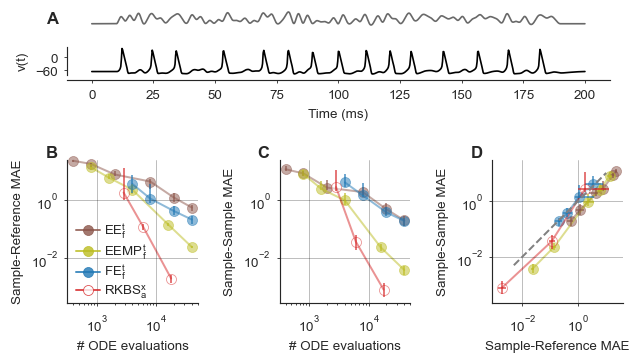

In [41]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs

stim = stims[1]

### Prepare axes ###
num_cols = 3
num_rows = 3

fig, axs = pltu.subplots(
    num_cols, num_rows, xsize='text',
    ysizerow=0.85, yoffsize=0.4, squeeze=False,
    gridspec_kw=dict(height_ratios=[0.1, 0.2, 1])
)

for ax in axs[:2, 1:].flat:
    ax.remove()
    
despine()

### Plot stimulus ###
row = df[(df.method=='EE') & (df.adaptive==0) & (df.step_param==0.25) & (df.stim==stim.name)]
assert len(row) == 1
row = row.iloc[0]
assert row.n_samples > 0, 'Pick an example that terminated'
    
stim_ts = np.arange(t0, tmax, 0.01)
plot_stim(ax=axs[0, 0], ts=stim_ts, stim=[row.stimfun.get_I_at_t(t=t) for t in stim_ts])
plot_vs(ax=axs[1, 0], ts=row.acc_ts, vs=row.acc_vs, c='k')
       
plot_MAE(ax=axs[2, 0], df=df[df.stim==stim.name], x='det_nODEcalls', y='MAE_SR', legend=True)
axs[2, 0].set(xscale='log', yscale='log', ylabel='Sample-Reference MAE', xlabel='# ODE evaluations')

plot_MAE(ax=axs[2, 1], df=df[df.stim==stim.name], x='det_nODEcalls', y='MAE_SM', legend=False)
axs[2, 1].set(xscale='log', yscale='log', ylabel='Sample-Sample MAE', xlabel='# ODE evaluations')

ax = axs[2, 2]
plot_MAE(ax=ax, df=df[df.stim==stim.name], x='MAE_SR', y='MAE_SM', legend=False)
ax.set(xscale='log', yscale='log', ylabel='Sample-Sample MAE', xlabel='Sample-Reference MAE',)
ax.axis('equal')

### Decorate ###
axs[0, 0].axis('off')
pltu.move_xaxis_outward(axs[1, :])
pltu.make_share_xlims(axs[:2, 0])
pltu.make_share_xlims(axs[2, :2])

ax = axs[2, 2]
ax.set_ylim(ax.get_ylim())
ylim = ax.get_ylim()
for ax in axs[2, :]:
    ax.set_ylim(ylim, auto=False)

ax.plot([5e-3, 10], [5e-3, 10], c='gray', ls='--')
    
plt.tight_layout(h_pad=0.3, pad=0.5, w_pad=2)

pltu.set_labs(axs[0,0], panel_nums='A', panel_num_va='top', panel_num_y=1, panel_num_space=2)
pltu.set_labs(axs[2,:], panel_nums=['B', 'C', 'D'], panel_num_va='bottom', panel_num_y=1, panel_num_space=2)

pltu.move_box(axs[1, :], dy=0.09)
pltu.change_box(axs=axs[:2, 0], dx=0.66, dy=0)

pltu.savefig("fig5")
plt.show()

## Text

In [48]:
for method, group in df.groupby('method'):
    print(method, group[group.n_samples > 0].step_param.max())

EE 0.5
EEMP 0.5
FE 0.05
RKBS 0.01
